In [96]:
from bs4 import BeautifulSoup
import bs4
import requests
import requests_cache
import re
import pandas as pd
import seaborn as sns
import plotly.express as px
from tqdm import tqdm
import numpy as np

requests_cache.install_cache("bases_scraping", expire_after=10e5)

In [97]:
# On désactive les écritures scientifiques
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [98]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'
}

In [99]:
secteur = "75000"
url = f"https://www.paruvendu.fr/immobilier/annonceimmofo/liste/listeAnnonces?tt=1&tbApp=1&tbDup=1&tbChb=1&tbLof=1&tbAtl=1&tbPla=1&tbMai=1&tbVil=1&tbCha=1&tbPro=1&tbHot=1&tbMou=1&tbFer=1&at=1&pa=FR&lol=0&ray=50&codeINSEE={secteur},"
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, "html.parser")

In [100]:
def get_nb_pages():
    string = soup.find("div", class_="resume").span.text
    a = int(string.split("-")[0])
    b = int(string.split("-")[1].split("sur")[0])
    c = int(string.split("-")[1].split("sur")[1].replace("annonces","").replace(" ",""))    
    return c // (b-a)

nb_pages = get_nb_pages()
nb_pages

85

In [128]:
prices = []
surfaces = []
types = []
pieces = []
cps = []

for i in tqdm(range(1,nb_pages+1)):
    url = f"https://www.paruvendu.fr/immobilier/annonceimmofo/liste/listeAnnonces?tt=1&tbApp=1&tbDup=1&tbChb=1&tbLof=1&tbAtl=1&tbPla=1&tbMai=1&tbVil=1&tbCha=1&tbPro=1&tbHot=1&tbMou=1&tbFer=1&at=1&pa=FR&lol=0&ray=50&codeINSEE={secteur},,&p={i}"
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")
    
    for annonce in soup.find_all('div', class_="ergov3-annonce"):
        try:
            # prix du bien
            price = annonce.find('div', class_="ergov3-priceannonce")
            price = int(price.text.replace(" ","").replace("€","").replace("\n","").replace("*","").replace("\r",""))
            #print(re.sub(r'(\s+){2,}|(\*)', ' ', annonce.find('div', class_='ergov3-priceannonce').text))

            # Titre de l'annonce. Permet de déduire le nombre de pièce, la surface et le type de bien
            txt = annonce.find('div', class_="ergov3-txtannonce")
            #print(re.sub(r"""[!?'".<>(){}@%&*/[/]""", " ",txt.h3.text ))
            # type de bien
            type_bien = txt.h3.text.split('\r\n')[1]

            # nombre de pièce du bien
            nb_pieces = txt.h3.text.split('\r\n')[2]

            # surface du bien
            surface = txt.h3.span.text.split(",")[-1].split("-")[-1].replace("m²","").replace(" ","").replace("\t","").replace("\n","").replace("\r","").replace("carrez","")

            # Code postal de l'annonce
            #cp = txt.cite.text.replace("(","").replace(")","").split(' ')[1].replace("\t","").replace("\n","").replace("\r","")
            #cp = re.sub(r'\r\n','',txt.cite.text)
            cp = re.sub(r'[^\d]+', '', txt.cite.text)  
            if cp=='':
                cp='0'
            # Ajout des caractéristiques dans des tableaux
            price = int(price)
            surface = int(surface)
            nb_pieces = int(nb_pieces)
            #type_bien = str(type_bien)
            #cps = int(cp)

            prices.append(price)
            surfaces.append(surface)
            pieces.append(nb_pieces)
            types.append(type_bien)
            cps.append(cp)

        except Exception as e:
           pass

df = pd.DataFrame(data={
    "price": prices,
    "surface": surfaces,
    "pieces": pieces,
    "types": types,
    "code postal": cps,
})

df["prix au m2"] = df["price"]/df["surface"]
df.head()

100%|██████████| 85/85 [00:11<00:00,  7.41it/s]


,price,surface,pieces,types,code postal,prix au m2
0,276000,214,7,Appartement,13,1289.720
1,550000,87,4,Appartement,19,6321.839
2,458000,48,2,Appartement,19,9541.667
3,424000,59,3,Appartement,19,7186.441
4,335000,37,2,Appartement,12,9054.054


In [129]:
df['code postal'] = df['code postal'].astype(np.int16)

In [130]:
df.groupby("pieces").mean()

,price,surface,code postal,prix au m2
pieces,,,,
1,253417.195,21.780,160.085,11884.332
2,468795.519,41.706,95.945,11334.346
3,726503.400,65.183,65.427,11044.542
4,1043444.576,91.330,93.557,11254.111
5,1568165.360,125.086,166.266,12206.171
6,1934706.522,157.391,429.022,12052.393
7,2082555.556,201.389,10.444,10800.267
8,3914166.667,323.333,1608.333,12391.935
9,4089500.000,366.250,2402.750,10356.597


<AxesSubplot:xlabel='pieces'>

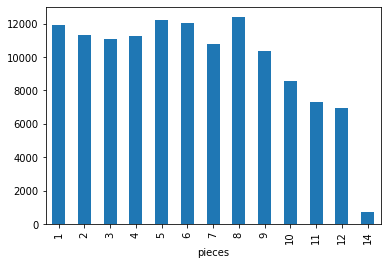

In [131]:
df.groupby("pieces").mean()['prix au m2'].plot(kind="bar")

In [132]:
df_price_surface = df.groupby(["pieces", "code postal"]).mean()
df_price_surface.head()

price  surface  prix au m2
pieces code postal                                
1      0           625000.000   80.000    7812.500
       1           422500.000   30.500   13870.968
       2           217444.444   17.444   13025.393
       3           232444.444   18.889   12190.466
       4           343250.000   25.625   13798.111

In [133]:
pieces = df["pieces"].unique().tolist()
secteurs = df["code postal"].unique().tolist()

data = []
for s in secteurs:
    secteur_i = []
    df_secteur_i = df[df['code postal'] == s]
    for p in pieces:
        secteur_i.append(df_secteur_i.loc[df_secteur_i['pieces'] == p, "prix au m2"].mean())
    data.append(secteur_i)
pieces, secteurs

([7, 4, 2, 3, 1, 6, 5, 8, 10, 11, 14, 12, 9],
 [13,
  19,
  12,
  20,
  18,
  7,
  9,
  5,
  9580,
  15,
  17,
  14,
  1,
  16,
  10,
  6,
  11,
  2,
  8,
  4,
  3,
  75,
  1975,
  1875,
  2075,
  475,
  0])

In [136]:
df_heatmap = pd.pivot_table(df, values='prix au m2', columns=['pieces'], index=['code postal'], aggfunc=np.mean).sort_index()

In [139]:
df_heatmap.values.shape

(27, 13)

In [141]:
len(df_heatmap.index)

27

In [143]:
len(df_heatmap.columns)

13

In [147]:
data = df_heatmap.values
data = np.nan_to_num(data, copy=True, nan=0.0)
data

array([[ 7812.5       ,     0.        ,  7032.78688525,  9833.33333333,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ],
       [13870.96774194, 14903.05982478, 18077.83018868, 11127.74902825,
        10255.95238095,     0.        ,  1046.77419355,     0.        ,
            0.        ,     0.        ,     0.        ,  1629.03225806,
         1400.        ],
       [13025.39304425, 13935.36686638, 12716.01633139,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ],
       [12190.46637742, 13743.33454736, 12813.7379804 , 12447.38520408,
        14251.41723356,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ],
       [13798.11126677, 15227.261118

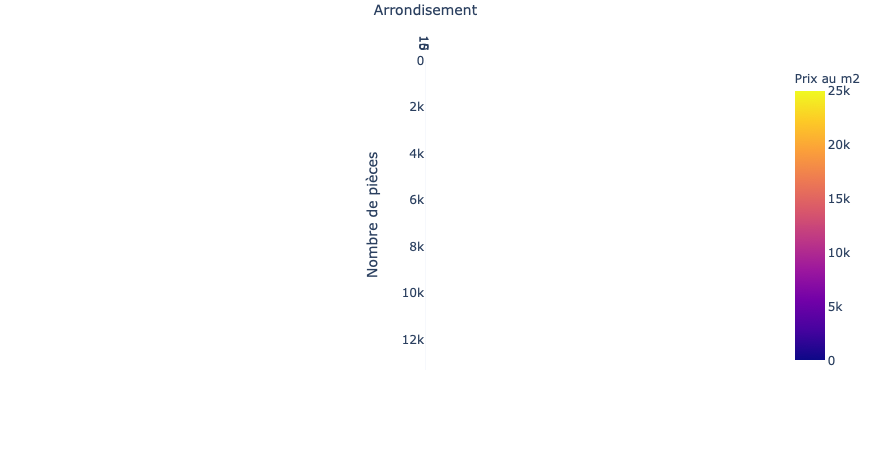

In [148]:
fig = px.imshow(data,
                labels=dict(x="Arrondisement", y="Nombre de pièces", color="Prix au m2"),
                x=df_heatmap.columns,
                y=df_heatmap.index
               )
fig.update_xaxes(side="top")
fig.show()

In [86]:
pd.DataFrame(data)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,3815.226,9994.081,10455.683,10219.371,12006.636,14611.499,10723.950,nan,nan,nan,nan,nan,nan
1,13771.213,8829.212,9612.469,9271.830,10159.209,8992.806,8209.894,nan,nan,nan,nan,nan,nan
2,nan,10471.078,10575.051,10197.812,11251.961,11438.849,8855.836,11218.750,nan,nan,nan,12220.339,nan
3,nan,9129.255,10164.753,9748.336,10506.690,11707.141,11200.435,8701.299,8571.429,nan,nan,nan,nan
4,nan,10667.431,10419.826,10167.627,10381.733,11896.552,11705.758,nan,nan,nan,nan,nan,nan
5,15469.373,15809.524,15306.491,14863.645,14549.476,17222.483,18153.068,nan,nan,nan,nan,nan,1527.027
6,nan,12034.337,12836.374,11945.686,12380.141,12140.145,12143.451,nan,nan,nan,nan,nan,nan
7,25000.000,15437.500,13766.590,15323.175,12749.367,nan,14221.154,nan,nan,nan,nan,nan,nan
8,nan,12493.923,14634.911,10746.282,16150.119,14477.133,12882.919,22064.057,nan,nan,nan,nan,24488.636
9,nan,11843.707,11119.783,10912.631,12057.918,4953.861,10688.241,nan,nan,7333.333,nan,nan,nan


In [ ]:
import plotly.express as px
data=[[1, 25, 30, 50, 1], [20, 1, 60, 80, 30], [30, 60, 1, 5, 20]]
fig = px.imshow(data,
                labels=dict(x="Day of Week", y="Time of Day", color="Productivity"),
                x=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
                y=['Morning', 'Afternoon', 'Evening']
               )
fig.update_xaxes(side="top")
fig.show()

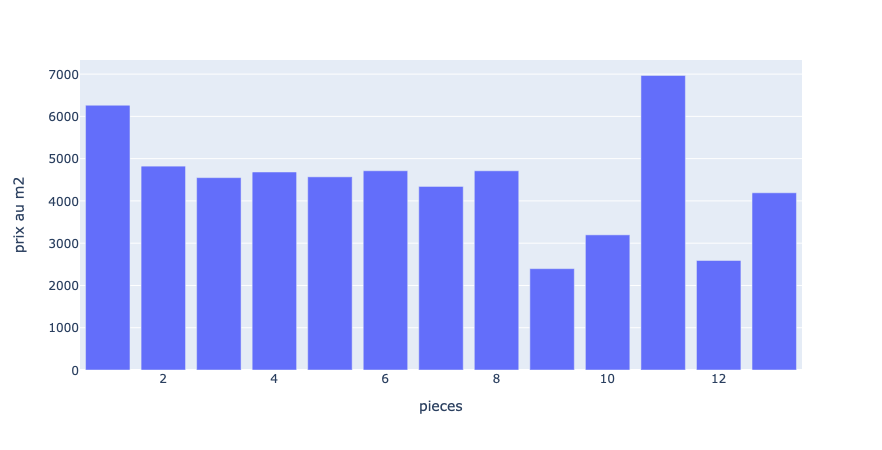

In [63]:
fig = px.bar(df_price_surface, x=df_price_surface.index, y="prix au m2")
fig.show()

In [36]:
df.groupby("code postal").mean()

,price,surface,pieces,prix au m2
code postal,,,,
Rennes (35000),412207.782,91.519,3.821,4722.373
Rennes (35200),320715.391,85.652,3.870,3631.034
Rennes (35700),333686.696,76.826,3.522,4423.801


/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='prix au m2'>

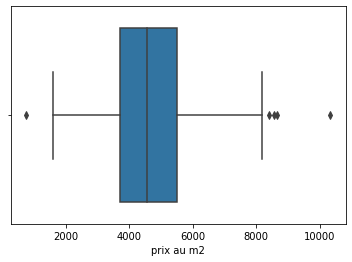

In [37]:
sns.boxplot(df["prix au m2"])

In [39]:
filtre = (df["code postal"] == "Rennes (35000)") & (df["pieces"] == 1)


df_filtre = df[filtre]
df_filtre.head()

,price,surface,pieces,types,code postal,prix au m2
21,185000,31,1,Appartement,Rennes (35000),5967.742
32,177650,30,1,Appartement,Rennes (35000),5921.667
43,182500,27,1,Appartement,Rennes (35000),6759.259
53,131000,21,1,Appartement,Rennes (35000),6238.095
64,127000,30,1,Appartement,Rennes (35000),4233.333


/Users/adrien/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='prix au m2'>

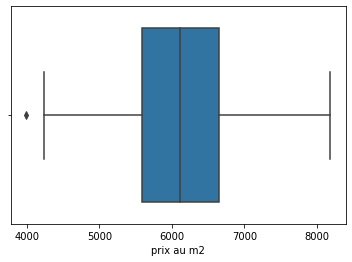

In [41]:
sns.boxplot(df_filtre["prix au m2"])

In [43]:
df_filtre.sort_values(by="price")

,price,surface,pieces,types,code postal,prix au m2
138,59000,9,1,Appartement,Rennes (35000),6555.556
139,59000,9,1,Appartement,Rennes (35000),6555.556
154,82900,15,1,Appartement,Rennes (35000),5526.667
252,103000,19,1,Appartement,Rennes (35000),5421.053
171,113184,20,1,Appartement,Rennes (35000),5659.200
208,125700,22,1,Appartement,Rennes (35000),5713.636
64,127000,30,1,Appartement,Rennes (35000),4233.333
169,131000,16,1,Appartement,Rennes (35000),8187.500
53,131000,21,1,Appartement,Rennes (35000),6238.095
123,131500,33,1,Appartement,Rennes (35000),3984.848


In [44]:
df_filtre.sort_values(by="prix au m2")

,price,surface,pieces,types,code postal,prix au m2
123,131500,33,1,Appartement,Rennes (35000),3984.848
64,127000,30,1,Appartement,Rennes (35000),4233.333
71,149000,34,1,Appartement,Rennes (35000),4382.353
255,137000,26,1,Appartement,Rennes (35000),5269.231
252,103000,19,1,Appartement,Rennes (35000),5421.053
154,82900,15,1,Appartement,Rennes (35000),5526.667
171,113184,20,1,Appartement,Rennes (35000),5659.200
208,125700,22,1,Appartement,Rennes (35000),5713.636
32,177650,30,1,Appartement,Rennes (35000),5921.667
21,185000,31,1,Appartement,Rennes (35000),5967.742
